In [ ]:
pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
from zipfile import ZipFile
import tensorflow
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.model_selection import KFold
import imgaug.augmenters as iaa
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import recall_score
from keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from sklearn.metrics import roc_curve, auc
from scipy.special import expit as sigmoid
from numpy import interp

In [ ]:
uploaded = files.upload()

Saving preprocessed_data_0.zip to preprocessed_data_0.zip
Saving preprocessed_data_1.zip to preprocessed_data_1.zip


In [ ]:
file1='/content/preprocessed_data_0.zip'
with ZipFile(file1,'r') as zip_ref:
    zip_ref.extractall('data_0')
file2='/content/preprocessed_data_1.zip'
with ZipFile(file2,'r') as zip_ref:
    zip_ref.extractall('data_1')
print('done')

done


In [ ]:
def load_images (directory):
    images = []
    for filename in os.listdir(directory):
      image_path = os.path.join(directory, filename)
      image = Image.open(image_path)
      resized_img = image.resize((256,256))
      image_array = np.array(resized_img)
      img_norm = image_array.astype(np.float32)
      img_norm /= 255.0
      images.append(img_norm)
    return images

In [ ]:
path_data_0='/content/data_0'
path_data_1='/content/data_1'
x_0 = np.array(load_images(path_data_0))
x_1 = np.array(load_images(path_data_1))

In [ ]:
print('dimensions du dataset 0:', x_0.shape, 'dimensions du dataset 1:', x_1.shape, sep="\n")

dimensions du dataset 0:
(34, 256, 256, 3)
dimensions du dataset 1:
(109, 256, 256, 3)


In [ ]:
all_data = np.concatenate((x_0, x_1), axis=0)
print('dimensions de all_data:', all_data.shape)

dimensions de all_data: (143, 256, 256, 3)


In [ ]:
y_0 = np.zeros(x_0.shape[0])
y_1 = np.ones(x_1.shape[0])
all_labels = np.concatenate((y_0, y_1), axis=0)

In [ ]:
random_state = 42 # Fixez la graine aléatoire pour obtenir des résultats reproductibles
rng = np.random.RandomState(random_state)
indices = np.arange(all_data.shape[0])
rng.shuffle(indices)
shuffled_data = all_data[indices]
shuffled_labels = all_labels[indices]

In [ ]:
augmentation_seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Flip horizontal avec une probabilité de 0.5
    iaa.Flipud(0.2),
    iaa.Affine(rotate=(-15, 15), shear=(-10, 10)),  # Rotation dans la plage -10 à 10 degrés et couper
    iaa.GaussianBlur(sigma=(0, 1.0)) # Flou gaussien avec une valeur de sigma aléatoire
], random_order=True)

In [ ]:
model_ResNet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in model_ResNet.layers:
    layer.trainable = False
model_ResNet.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [ ]:
x = GlobalAveragePooling2D()(model_ResNet.output)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_final01 = Model(inputs=model_ResNet.input, outputs=output) # pour créer le modèle final 01
model_final01.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
k= 5
kf= KFold(n_splits=k)
#batch_size= 5
#epochs=10
scores_acc= []
roc_results= []
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
for train_index, test_index in kf.split(shuffled_data):
    X_train, X_test = shuffled_data[train_index], shuffled_data[test_index]
    #print("Nombre d'images train:", len(X_train)) #114
    #print("Nombre d'images test:", len(X_test)) #29
    y_train, y_test = shuffled_labels[train_index], shuffled_labels[test_index]
    X_train_augmented = augmentation_seq.augment_images(X_train)
    model_final01.fit(X_train_augmented, y_train, callbacks=[early_stopping])
    y_pred = model_final01.predict(X_test)
    y_pred_proba = sigmoid(y_pred)  # Appliquer une fonction d'activation
    y_pred_proba = y_pred_proba.squeeze()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_results.append((fpr, tpr, roc_auc))
    accuracy = model_final01.evaluate(X_test, y_test)
    scores_acc.append(accuracy)

1/1 [==============================] - 6s 6s/step - loss: 0.5628 - accuracy: 0.7857


In [ ]:
print('accuracy:', scores_acc)

accuracy: [[0.6006237268447876, 0.7241379022598267], [0.7167955040931702, 0.6551724076271057], [0.40493130683898926, 0.8620689511299133], [0.5296533703804016, 0.7857142686843872], [0.5627776980400085, 0.7857142686843872]]


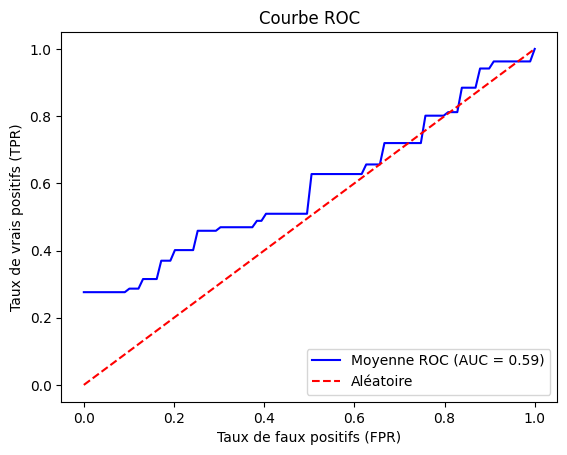

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_results], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Moyenne ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_VGG16 = VGG16(weights='imagenet', include_top=False)
for layer in model_VGG16.layers:
    layer.trainable = False
model_VGG16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
x = GlobalAveragePooling2D()(model_VGG16.output)
x = Flatten()(x)
x = Dense(18, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_final02 = Model(inputs=model_VGG16.input, outputs=output)
model_final02.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
scores_acc= []
roc_results= []
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
for train_index, test_index in kf.split(shuffled_data):
    X_train, X_test = shuffled_data[train_index], shuffled_data[test_index]
    #print("Nombre d'images train:", len(X_train)) #114
    #print("Nombre d'images test:", len(X_test)) #29
    y_train, y_test = shuffled_labels[train_index], shuffled_labels[test_index]
    X_train_augmented = augmentation_seq.augment_images(X_train)
    model_final02.fit(X_train_augmented, y_train, callbacks=[early_stopping])
    y_pred = model_final02.predict(X_test)
    y_pred_proba = sigmoid(y_pred)  # Appliquer une fonction d'activation
    y_pred_proba = y_pred_proba.squeeze()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_results.append((fpr, tpr, roc_auc))
    accuracy = model_final02.evaluate(X_test, y_test)
    scores_acc.append(accuracy)

1/1 [==============================] - 19s 19s/step - loss: 0.5117 - accuracy: 0.7857


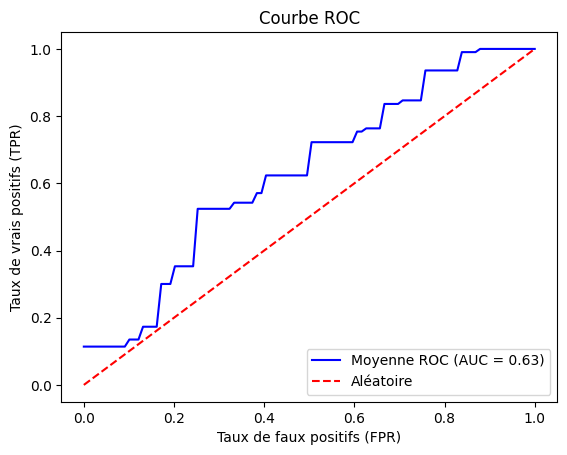

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_results], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Moyenne ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

In [ ]:
model_Xception = Xception(weights='imagenet', include_top=False)
for layer in model_Xception.layers:
    layer.trainable = False
model_Xception.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                   

In [ ]:
x = model_Xception.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(18, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model_final03= Model(inputs= model_Xception.input, outputs=output)
model_final03.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
scores_acc= []
roc_results= []
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
for train_index, test_index in kf.split(shuffled_data):
    X_train, X_test = shuffled_data[train_index], shuffled_data[test_index]
    #print("Nombre d'images train:", len(X_train)) #114
    #print("Nombre d'images test:", len(X_test)) #29
    y_train, y_test = shuffled_labels[train_index], shuffled_labels[test_index]
    X_train_augmented = augmentation_seq.augment_images(X_train)
    model_final03.fit(X_train_augmented, y_train, callbacks=[early_stopping])
    y_pred = model_final03.predict(X_test)
    y_pred_proba = sigmoid(y_pred)  # Appliquer une fonction d'activation
    y_pred_proba = y_pred_proba.squeeze()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_results.append((fpr, tpr, roc_auc))
    accuracy = model_final03.evaluate(X_test, y_test)
    scores_acc.append(accuracy)

1/1 [==============================] - 7s 7s/step - loss: 0.4875 - accuracy: 0.7857


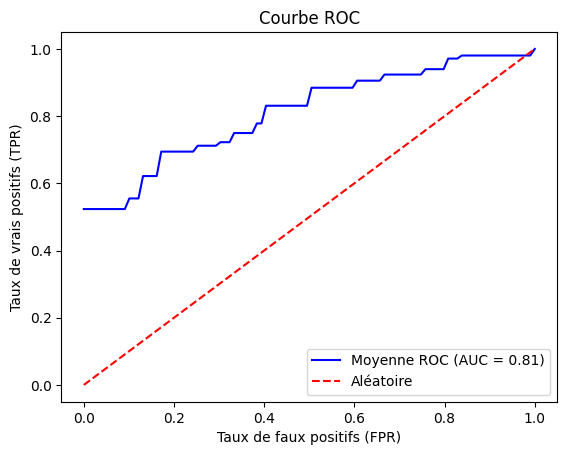

In [ ]:
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_results], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='b', label=f'Moyenne ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Aléatoire')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()